Импортируем нужные библиотеки.

In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from catboost import CatBoostClassifier

Распакуйте архив с данными в папку,где находится этот jupyter notebook (baseline.ipynb). У вас будет папка data,  содержащая необходимые файлы. 

Ваша задача предсказать вероятность совершения покупки Клиентом в определенных 8 категориях в следующие 7 дней, чтобы под них Банк смог направить релевантный контент (подборки). Для подготовки предсказания у вас есть данные по транзакциям 50 000 Клиентов в течение года, из которых 25 000 – в обучающей выборке и 25 000 – в тестовой. Ваша задача для тестовой выборки рассчитать для каждой из целевой категории вероятность совершения покупки в ней на следующей неделе.

Данные по транзакциям находятся в файле **transactions_train.csv**. Информация о покупках по категориям для исследуемой недели находится в файле **train_target.csv**.

Считаем данные по транзакциям и правильные ответы.

In [2]:
transactions_train = pd.read_csv('transactions_train.csv')
train_target = pd.read_csv('train_target.csv')
transactions_test = pd.read_csv('transactions_test.csv')
test_id = pd.read_csv('test.csv')

In [3]:
def get_amount_features(transactions, name):
    amount_cat = transactions.groupby(['client_dk','small_group']).sum()['amount']
    amount_cat = amount_cat.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')
    amount_cat = amount_cat.fillna(0)
    amount_cat.columns = [name + str(i) for i in amount_cat.columns]
    return amount_cat

def get_count_features(transactions, name):
    counter_df = transactions.groupby(['client_dk','small_group'])['amount'].count()
    cat_counts = counter_df.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')
    cat_counts = cat_counts.fillna(0)
    cat_counts.columns = [name + str(i) for i in cat_counts.columns]
    return cat_counts


def get_features(transactions, target):
    agg_features = transactions.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()
    
    count_cat = get_count_features(transactions, 'cat_count_')
    amount_cat = get_amount_features(transactions, 'cat_spend_')
    
    amount_cat_last_week = get_amount_features(transactions[transactions.trans_date > 380], 'cat_spend_last_week_')
    count_cat_last_week = get_count_features(transactions[transactions.trans_date > 380], 'cat_count_last_week_')  
    
    amount_cat_last_2weeks = get_amount_features(transactions[transactions.trans_date > 373], 'cat_spend_last_2weeks_')
    count_cat_last_2weeks = get_count_features(transactions[transactions.trans_date > 373], 'cat_count_last_2weeks_')   
    
    amount_cat_last_month = get_amount_features(transactions[transactions.trans_date > 357], 'cat_spend_last_month_')
    count_cat_last_month = get_count_features(transactions[transactions.trans_date > 357], 'cat_count_last_month_')    
    
    amount_cat_sport_peak = get_amount_features(transactions[(transactions.trans_date >= 283) & (transactions.trans_date <= 300)], 'cat_spend_sport_peak_')
    count_cat_sport_peak = get_count_features(transactions[(transactions.trans_date >= 283) & (transactions.trans_date <= 300)], 'cat_count_sport_peak_')    
    
    amount_cat_flower_peak = get_amount_features(transactions[(transactions.trans_date >= 126) & (transactions.trans_date <= 127)], 'cat_spend_flower_peak_')
    count_cat_flower_peak = get_count_features(transactions[(transactions.trans_date >= 126) & (transactions.trans_date <= 127)], 'cat_count_flower_peak_')    
   
    amount_cat_week_year_ago = get_amount_features(transactions[(transactions.trans_date >= 333) & (transactions.trans_date <= 339)], 'cat_spend_week_year_ago_')
    count_cat_week_year_ago = get_count_features(transactions[(transactions.trans_date >= 333) & (transactions.trans_date <= 339)], 'cat_count_week_year_ago_')   
    
    out = pd.merge(target, agg_features, on='client_dk', how='outer')
    out = pd.merge(out, count_cat.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_last_week.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_last_week.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_last_2weeks.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_last_2weeks.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_last_month.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_last_month.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_sport_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_sport_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_flower_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_flower_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_week_year_ago.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_week_year_ago.reset_index(), on='client_dk', how='outer')
    
    return out

In [4]:
train = get_features(transactions_train, train_target)

In [5]:
test = get_features(transactions_test, test_id[['client_dk']])

In [6]:
common_features = list(set(test.columns).intersection(set(train.columns)))
cf = []
for i in common_features:
    if "cat" in i:
        if "_27" in i or "_32" in i or "_41" in i or "_45" in i or "_67" in i or "_73" in i or "_81" in i or "_88" in i or ("flower" in i and "_37" in i):
            cf.append(i)
    else:
        cf.append(i)

In [7]:
common_features = cf

In [8]:
X_train = train[common_features]
X_test = test[common_features]

В этом бэйзлайне мы будем использовать простой подход - предсказывать покупки в каждой категории независимо. То есть в цикле модель обучается на отдельную категорию как на зависимую переменную, и пытается предсказать наличие покупки в этой определенной категории для теста. В итоге у нас получается 8 задач бинарной классификации.

**Важно**: Такой подход не претендует на звание лучшего, вы вольны придумать свой алгоритм решения, который, вполне вероятно, окажется лучше.

In [9]:
params = {
    'n_estimators': 1000,
    'depth': 6,
    'random_state':42,
    'learning_rate': 0.027,
    'eval_metric': 'AUC',
    'loss_function': 'MultiClass',
    'verbose': 1000, 
    
}

In [10]:
#В словарь будем записывать предсказания модели
results_tree = {}
main_result = [] 
#Цикл со второго элемента, потому что первой колонкой идет идентификатор клиента 
for q in train_target.columns[1:]:
    print('train product '+str(q))
    curr_target_train = train_target.loc[:,q]
    model = CatBoostClassifier(**params)
    #model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train.fillna(0).values,curr_target_train.values)
    main_result.append(model.get_evals_result())
    #Сделаем предсказание
    pred = model.predict_proba(X_test.fillna(0).values)[:,1]
    results_tree[q] = pred

train product 27
0:	total: 201ms	remaining: 3m 20s
999:	total: 25.2s	remaining: 0us
train product 32
0:	total: 30.5ms	remaining: 30.4s
999:	total: 27.5s	remaining: 0us
train product 41
0:	total: 31.9ms	remaining: 31.9s
999:	total: 25.9s	remaining: 0us
train product 45
0:	total: 33.6ms	remaining: 33.6s
999:	total: 25.3s	remaining: 0us
train product 67
0:	total: 35.2ms	remaining: 35.2s
999:	total: 24s	remaining: 0us
train product 73
0:	total: 37.8ms	remaining: 37.7s
999:	total: 24.3s	remaining: 0us
train product 81
0:	total: 32.9ms	remaining: 32.9s
999:	total: 25.6s	remaining: 0us
train product 88
0:	total: 36.9ms	remaining: 36.9s
999:	total: 27.4s	remaining: 0us


Такое решение дает на публичном лидерборде качество 0.6023

### Подготовим файл для отправки в систему

In [11]:
submission = pd.DataFrame(data=np.zeros((25000,8)),columns=train_target.columns[1:],index=test_id['client_dk'].values)

In [12]:
for q in results_tree:
    submission[q] = results_tree[q]
submission.columns = ['cat_27','cat_32','cat_41','cat_45','cat_67','cat_73','cat_81','cat_88']

In [13]:
submission.index.name = 'client_dk'

Сохраняем прогноз на диск в папку submissions. Имя прогноза соответсвует дате и времени его создания, закодированными с помощью timestamp.

In [14]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
submission.to_csv(submission_path, index=True)

submissions/1583489002.csv


Теперь все готово! Можно отправлять решение.

In [15]:
import matplotlib.pyplot as plt
plt.plot(main_result[0]['learn']['MultiClass']) #27.Спортивные мероприятия - синий
plt.plot(main_result[1]['learn']['MultiClass']) # 32. Театр - оранжевый
plt.plot(main_result[2]['learn']['MultiClass']) # 41.Ночной клуб - зеленый
plt.plot(main_result[3]['learn']['MultiClass']) # 45.Кинотеатры - красный
plt.plot(main_result[4]['learn']['MultiClass']) # 67.Доставка еды - фиолетовый светлый
plt.plot(main_result[5]['learn']['MultiClass']) # 73.Выставки - фиолетовый темный
plt.plot(main_result[6]['learn']['MultiClass']) # 81.Билеты на спортивные мероприятия - розовый
plt.plot(main_result[7]['learn']['MultiClass']) # 88.Цирк - черный

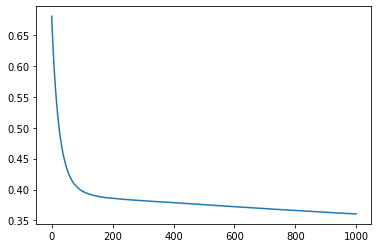

In [16]:
plt.plot(main_result[1]['learn']['MultiClass']) #32.Театр


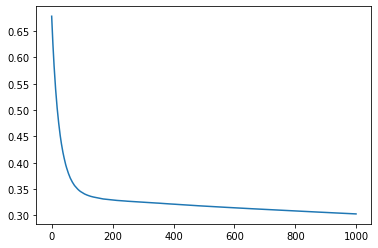

In [17]:
plt.plot(main_result[2]['learn']['MultiClass']) #33. Ночные клубы